In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

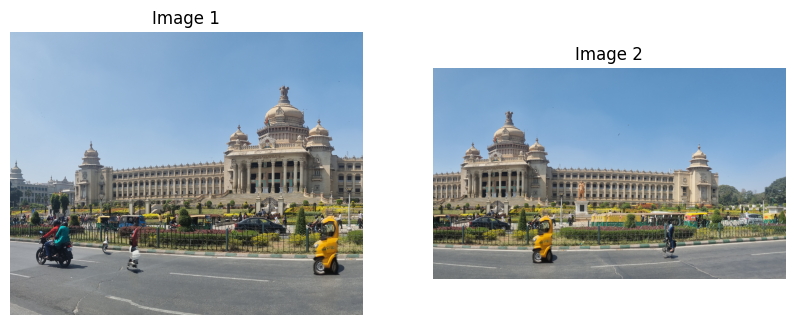

In [53]:
# Reading images
image1=cv2.imread('vs1.jpg')
image2=cv2.imread('vs2.jpg')

# Displaying original images
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')
plt.show()

In [54]:
# Creating SIFT object, which will be used for applying SIFT on images
sift = cv2.xfeatures2d.SIFT_create()

# Detecting keypoints and computing keypoint descriptors for the 2 input images
keypointsImage1, descriptorImage1 = sift.detectAndCompute(image1,None)
keypointsImage2, descriptorImage2 = sift.detectAndCompute(image2,None)

# Writing the matches detected in the 2 images to the filesystem
Image1Keypoints=cv2.drawKeypoints(image1,keypointsImage1,None)
cv2.imwrite('vs1_keypoints.jpg',Image1Keypoints)
Image2Keypoints=cv2.drawKeypoints(image2,keypointsImage2,None)
cv2.imwrite('vs2_keypoints.jpg',Image2Keypoints)

True

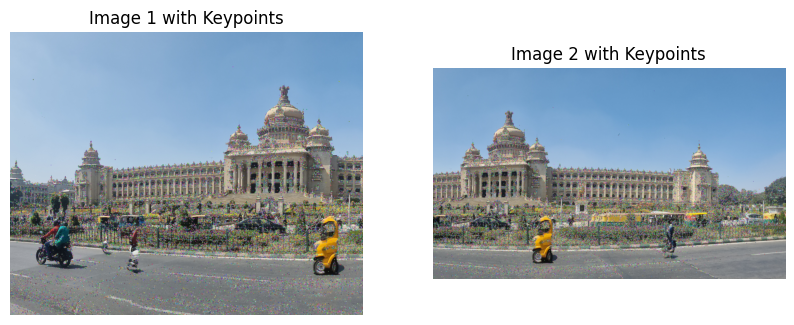

In [55]:
# Displaying images with keypoints
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(Image1Keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 1 with Keypoints')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(Image2Keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 2 with Keypoints')
plt.axis('off')
plt.show()

In [56]:
# Applying Brute Force matcher for getting K nearest neighbours for
# each keypoint using respective descriptors
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptorImage1, descriptorImage2, k=2)

goodList = []
good = []

# Filtering good matches based on a distance of 0.75 between
# keypoint pairs in 2 images
for m,n in matches:
    if m.distance < 0.75*n.distance:
        goodList.append([m])
        good.append(m)

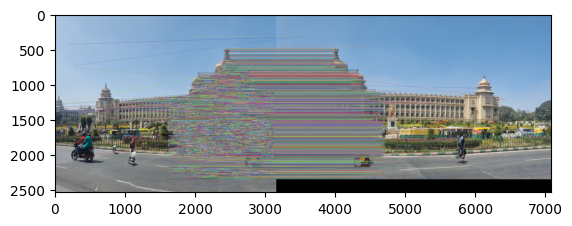

True

In [57]:
# Plotting knn matches based on the keypoint distances computed
# cv2.drawMatchesKnn expects list of lists as matkeypointsches
imagePlot = cv2.drawMatchesKnn(image1,keypointsImage1,image2,keypointsImage2,goodList,None,flags=2)
plt.imshow(cv2.cvtColor(imagePlot, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('matches_knn.jpg',imagePlot)

In [58]:
# Getting keypoint locations as an array of (x,y) coordinates
ptsImage1 = np.array([ keypointsImage1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
ptsImage2 = np.array([ keypointsImage2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

In [59]:
# Getting homography matrix after applying RANSAC on
# well matched keypoints on both images with projection error <= 1
H, mask = cv2.findHomography(ptsImage1, ptsImage2, cv2.RANSAC)
print('Homography Matrix:')
print(H)

Homography Matrix:
[[ 1.00013760e+00 -3.59950770e-06 -1.60256899e+03]
 [ 5.92623977e-06  1.00015756e+00 -2.64125117e-02]
 [ 9.28422693e-10 -4.24920263e-09  1.00000000e+00]]


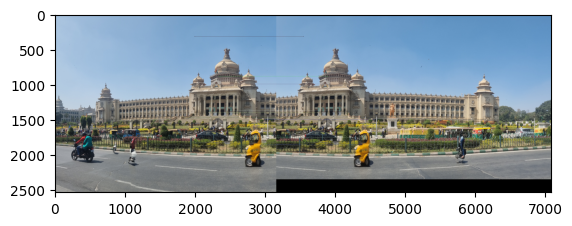

True

In [60]:
# Get 10 inlier matches after applying RANSAC
matchesMask = mask.ravel().tolist()
indices = []
for ind in range(len(matchesMask)):
    if matchesMask[ind] == 1:
        indices.append(ind)
matchesMask = [0]*len(matchesMask)
np.random.shuffle(indices)
indices = indices[:10]
for ind in indices:
        matchesMask[ind] = 1

# Drawing inliers
inlierImage = cv2.drawMatches(image1,keypointsImage1,image2,keypointsImage2,
                              good,None,matchesMask = matchesMask,flags = 2)
plt.imshow(cv2.cvtColor(inlierImage, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('matches.jpg',inlierImage)

In [61]:
# Getting corners of image 1 in the 2nd plane
h, w, d = image1.shape
image1Corners = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
image1CornersPlane2 = np.squeeze(cv2.perspectiveTransform(image1Corners,H))

# Computing the left most point (point corr. to xmin)
xMin = min(image1CornersPlane2[0][0], image1CornersPlane2[1][0])

# Computing the top most point (point corr. to ymin)
yMin = min(image1CornersPlane2[0][1], image1CornersPlane2[3][1])

# Computing the right most point (point corr. to xmax)
xMax = max(image1CornersPlane2[2][0], image1CornersPlane2[3][0])

# Computing the lowest point (point corr. to ymax)
yMax = max(image1CornersPlane2[1][1], image1CornersPlane2[2][1])

In [62]:
# The following function gives the max dimensions that image1 can
# take in the second plane (for displaying all pixels)
t1 = (xMax-xMin, yMax-yMin)
t2 = (len(image2[0])-int(xMin), len(image2)-int(yMin))
finalImageShape = max(t1,t2)

# Translation matrix, to translate image1 by dimensions which go out
# of the image returned from perspective warp due to -ve locations
if xMin < 0 and yMin < 0:
    translate = np.float32([[1,0, -xMin], [0,1, -yMin], [0,0,1]])
elif xMin < 0:
    translate = np.float32([[1,0, -xMin], [0,1,0], [0,0,1]])
elif xMin < 0:
    translate = np.float32([[1,0,0], [0,1, -yMin], [0,0,1]])
else:
    translate = np.float32([[1,0,0], [0,1,0], [0,0,1]])

In [63]:
# Applying homography to image1 to warp it to image2 with translation
finalImage = cv2.warpPerspective(image1, np.matmul(translate,H), finalImageShape)

# Slicing the image with warped image1 to place image2 as well
finalImage[-int(yMin):-int(yMin)+len(image2), -int(xMin):-int(xMin)+len(image2[0])]=image2

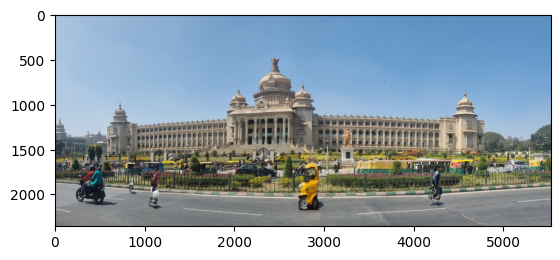

True

In [64]:
plt.imshow(cv2.cvtColor(finalImage, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('pano.jpg',finalImage)